In [1]:
import os, sys, ROOT
import uproot as np                                                    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Welcome to JupyROOT 6.08/06


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from mpid_data import mpid_data_binary
from mpid_net import mpid_net_binary, mpid_func

In [3]:
torch.cuda.is_available()

True

In [4]:
from lib.config import config_loader
MPID_PATH = os.path.dirname(mpid_data_binary.__file__)+"/../cfg"
CFG = os.path.join(MPID_PATH,"inference_config_binary.cfg")

# CFG = os.path.join("../../cfg","inference_config.cfg")
cfg  = config_loader(CFG)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=cfg.GPUID

self.adc_lo=float(10)
self.adc_hi=float(500)
self.augment=False
self.batch_size_train=int(1)
self.batch_size_test=int(1)
self.drop_out=0.0
self.EPOCHS=50
self.GPUID=str("1")
self.learning_rate=float(1e-3)
self.name=str("BN_False_LR-3_AG_True")
self.num_class=int(2)
self.plane=2
self.run_test=True
self.test_events_nums=9
self.test_every_step=10
self.weight_file_mpid_0=str("/scratch/ruian/training_data/weights/pid/plane0/pid-245199")
self.weight_file_mpid_1=str("/scratch/ruian/training_data/weights/pid/plane1/pid-355199")
self.weight_file_mpid_2=str("/scratch/ruian/training_data/weights/pid/plane2/pid-453799")
self.xdim=int(512)
self.ydim=int(512)


In [5]:
ls

Crop_test.ipynb
Crop_test_NCpi0.ipynb
Crop_test_help_function.ipynb
MCTruth_particles.ipynb
MPID_binary_example.ipynb
MPID_example.ipynb
check.ipynb
check_info.ipynb
crop_example.ipynb
dm_angles_v3.csv
dm_crop.root
dm_crop_1.root
dm_crop_2.root
dm_energies_v3.csv
dm_info.csv
dm_info_v3.csv
dm_signal_scores.csv
dm_signal_scores.xlsx
dm_test.ipynb
dm_vertex.csv
dm_vertex_v3.csv
ep_gamma_comparison.ipynb
gamma_sample_analysis.ipynb
imread.root
inference_DC_ccpi0_2nd_tagger_pytorch.ipynb
inference_sample01.ipynb
inference_test.ipynb
inference_test_six_labels.ipynb
mpid_model_20200226-12_53_AM_epoch_31_batch_id_1731_title_LR0.001_AG_GN_plane2_5labels_step_98048.pwf
mpid_model_20200830-01_37_PM_epoch_31_batch_id_1851_title_0.001_AG_GN_final_step_59542.pwf
mpid_model_20200830-06_40_PM_epoch_45_batch_id_1851_title_0.001_AG_GN_final_step_85596.pwf
mpid_model_20200901-09_45_PM_epoch_31_batch_id_561_labels_2_title_0.001_AG_GN_final_step_19750.pwf
mpid_model_20200914-08_42_PM_epoch_0_batch_id_501_

In [6]:
#weight_file="mpid_model_20200914-10_30_PM_epoch_3_batch_id_31_labels_2_title_0.001_AG_GN_final_2_classes_step_3784.pwf"
weight_file="mpid_model_20200914-08_45_PM_epoch_0_batch_id_641_labels_2_title_0.001_AG_GN_final_2_classes_step_641.pwf"
#weight_file='mpid_model_20200914-08_42_PM_epoch_0_batch_id_501_labels_2_title_0.001_AG_GN_final_2_classes_step_501.pwf'

In [7]:
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

mpid = mpid_net_binary.MPID()
mpid.cuda()

mpid.load_state_dict(torch.load(weight_file, map_location=train_device))

mpid.eval()

MPID(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): GroupNorm(64, 64, eps=1e-05, affine=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): GroupNorm(64, 64, eps=1e-05, affine=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): GroupNorm(96, 96, eps=1e-05, affine=True)
    (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): GroupNorm(96, 96, eps=1e-05, affine=True)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): GroupNorm(128, 128, eps=1e-05, affine=True)
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): GroupNorm(128, 128, eps=1e-05, affine=True)
    (20): AvgPool2d(kernel_size=2, str

In [8]:
test_file = "../MPID/input/test_set_binary.root"

test_data = mpid_data_binary.MPID_Dataset(test_file,"image2d_image2d_binary_tree", train_device)
test_loader = DataLoader(dataset=test_data, batch_size= 1 , shuffle=True)

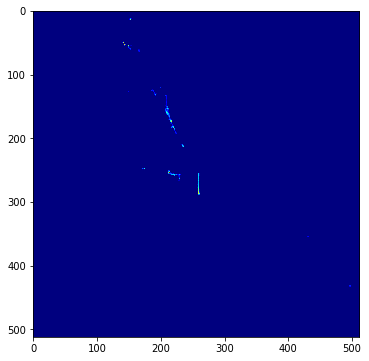

In [9]:
input_image = test_data[4350][0].view(-1,1,512,512)
fig, ax= plt.subplots(1,1,figsize=(7,6))
ax.imshow(input_image.cpu()[0][0], cmap='jet')

In [10]:
len(test_data)

5999

In [11]:
score_signal_dm = np.zeros(3000)
score_background_ncpi0 = np.zeros(2999)

score_background_dm = np.zeros(3000)
score_signal_ncpi0 = np.zeros(2999)

In [12]:
for ENTRY in range(5999):
    input_image = test_data[ENTRY][0].view(-1,1,512,512)

    input_image[0][0][input_image[0][0] > 500] = 500
    input_image[0][0][input_image[0][0] < 10 ] = 0
    score = nn.Sigmoid()(mpid(input_image.cuda())).cpu().detach().numpy()[0]
    
    if(ENTRY <= 2999):
        score_signal_dm[ENTRY] = score[0]
        score_background_dm[ENTRY] = score[1]
    else:
        score_signal_ncpi0[ENTRY - 3000] = score[0]
        score_background_ncpi0[ENTRY - 3000] = score[1]

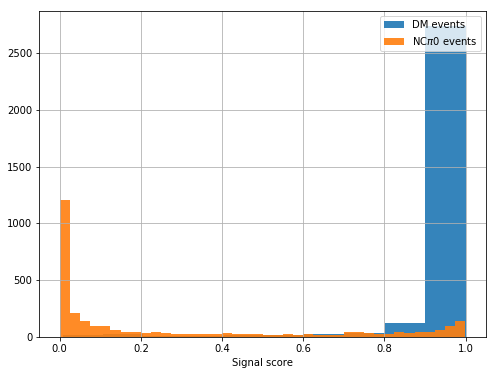

In [13]:
fig, ax = plt.subplots(1,1,figsize = (8,6))
ax.set_xlabel("Signal score")
ax.grid()
plt.hist(score_signal_dm, bins = 10, alpha=0.9, label='DM events',histtype='bar')
plt.hist(score_signal_ncpi0, bins = 40, alpha=0.9, label='NC$\pi$0 events',histtype='bar')
plt.legend(loc='upper right')
plt.show()

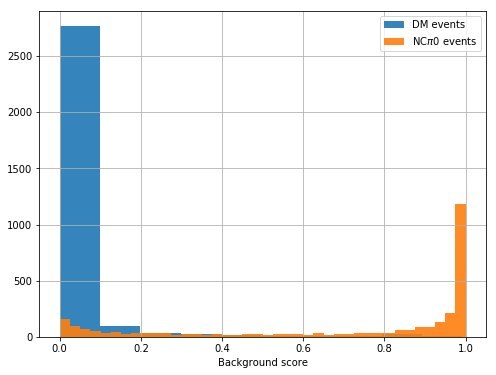

In [14]:
fig, ax = plt.subplots(1,1,figsize = (8,6))
ax.set_xlabel("Background score")
ax.grid()
plt.hist(score_background_dm, bins = 10, alpha=0.9, label='DM events',histtype='bar')
plt.hist(score_background_ncpi0, bins = 40, alpha=0.9, label='NC$\pi$0 events',histtype='bar')
plt.legend(loc='upper right')
plt.show()